In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
import seaborn as sns
import math
from scipy import stats
import cooler
import cooltools.lib.plotting
from cooltools import insulation

import itertools

import os
import sys

# local imports 
import filters
import pore_c_utils as pcu

In [2]:
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/matrix/"
cell = "run07"

filepath = f"{dirpath}NlaIII_{cell}_GRCm39_unphased.matrix.mcool"
print(filepath)

/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/matrix/NlaIII_run07_GRCm39_unphased.matrix.mcool


In [3]:
cooler.fileops.list_coolers(filepath)

['/resolutions/1000',
 '/resolutions/2000',
 '/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/25000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/250000',
 '/resolutions/500000',
 '/resolutions/1000000',
 '/resolutions/2500000',
 '/resolutions/5000000',
 '/resolutions/10000000']

# File Load

In [4]:
resolution = 1000000

clr = cooler.Cooler(f'{filepath}::resolutions/{resolution}')

In [5]:
### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

NC_000067.7 : (0, 196)
NT_166280.1 : (196, 197)
NT_166281.1 : (197, 198)
NT_166282.1 : (198, 199)
NT_162750.1 : (199, 200)
NW_023337852.1 : (200, 201)
NT_166338.1 : (201, 202)
NC_000068.8 : (202, 384)
NC_000069.7 : (384, 544)
NC_000070.7 : (544, 701)
NT_187055.1 : (701, 702)
NC_000071.7 : (702, 854)
NT_187056.1 : (854, 855)
NT_187057.1 : (855, 856)
NT_187058.1 : (856, 857)
NT_166438.1 : (857, 858)
NT_187059.1 : (858, 859)
NC_000072.7 : (859, 1009)
NC_000073.7 : (1009, 1154)
NT_166307.1 : (1154, 1155)
NC_000074.7 : (1155, 1286)
NC_000075.7 : (1286, 1411)
NC_000076.7 : (1411, 1542)
NC_000077.7 : (1542, 1664)
NC_000078.7 : (1664, 1785)
NC_000079.7 : (1785, 1906)
NC_000080.7 : (1906, 2032)
NC_000081.7 : (2032, 2137)
NC_000082.7 : (2137, 2236)
NC_000083.7 : (2236, 2332)
NC_000084.7 : (2332, 2423)
NC_000085.7 : (2423, 2485)
NC_000086.8 : (2485, 2655)
NT_165789.3 : (2655, 2656)
NC_000087.8 : (2656, 2748)
NT_187060.1 : (2748, 2749)
NT_187061.1 : (2749, 2750)
NT_187062.1 : (2750, 2751)
NT_18706

In [6]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [7]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [8]:
chromMap = dict(zip(assembly['RefSeq accession'], assembly['Chromosome']))
chromMap

{'NC_000067.7': '1',
 'NC_000068.8': '2',
 'NC_000069.7': '3',
 'NC_000070.7': '4',
 'NC_000071.7': '5',
 'NC_000072.7': '6',
 'NC_000073.7': '7',
 'NC_000074.7': '8',
 'NC_000075.7': '9',
 'NC_000076.7': '10',
 'NC_000077.7': '11',
 'NC_000078.7': '12',
 'NC_000079.7': '13',
 'NC_000080.7': '14',
 'NC_000081.7': '15',
 'NC_000082.7': '16',
 'NC_000083.7': '17',
 'NC_000084.7': '18',
 'NC_000085.7': '19',
 'NC_000086.8': 'X',
 'NC_000087.8': 'Y'}

Text(0, 0.5, 'Position (Mb)')

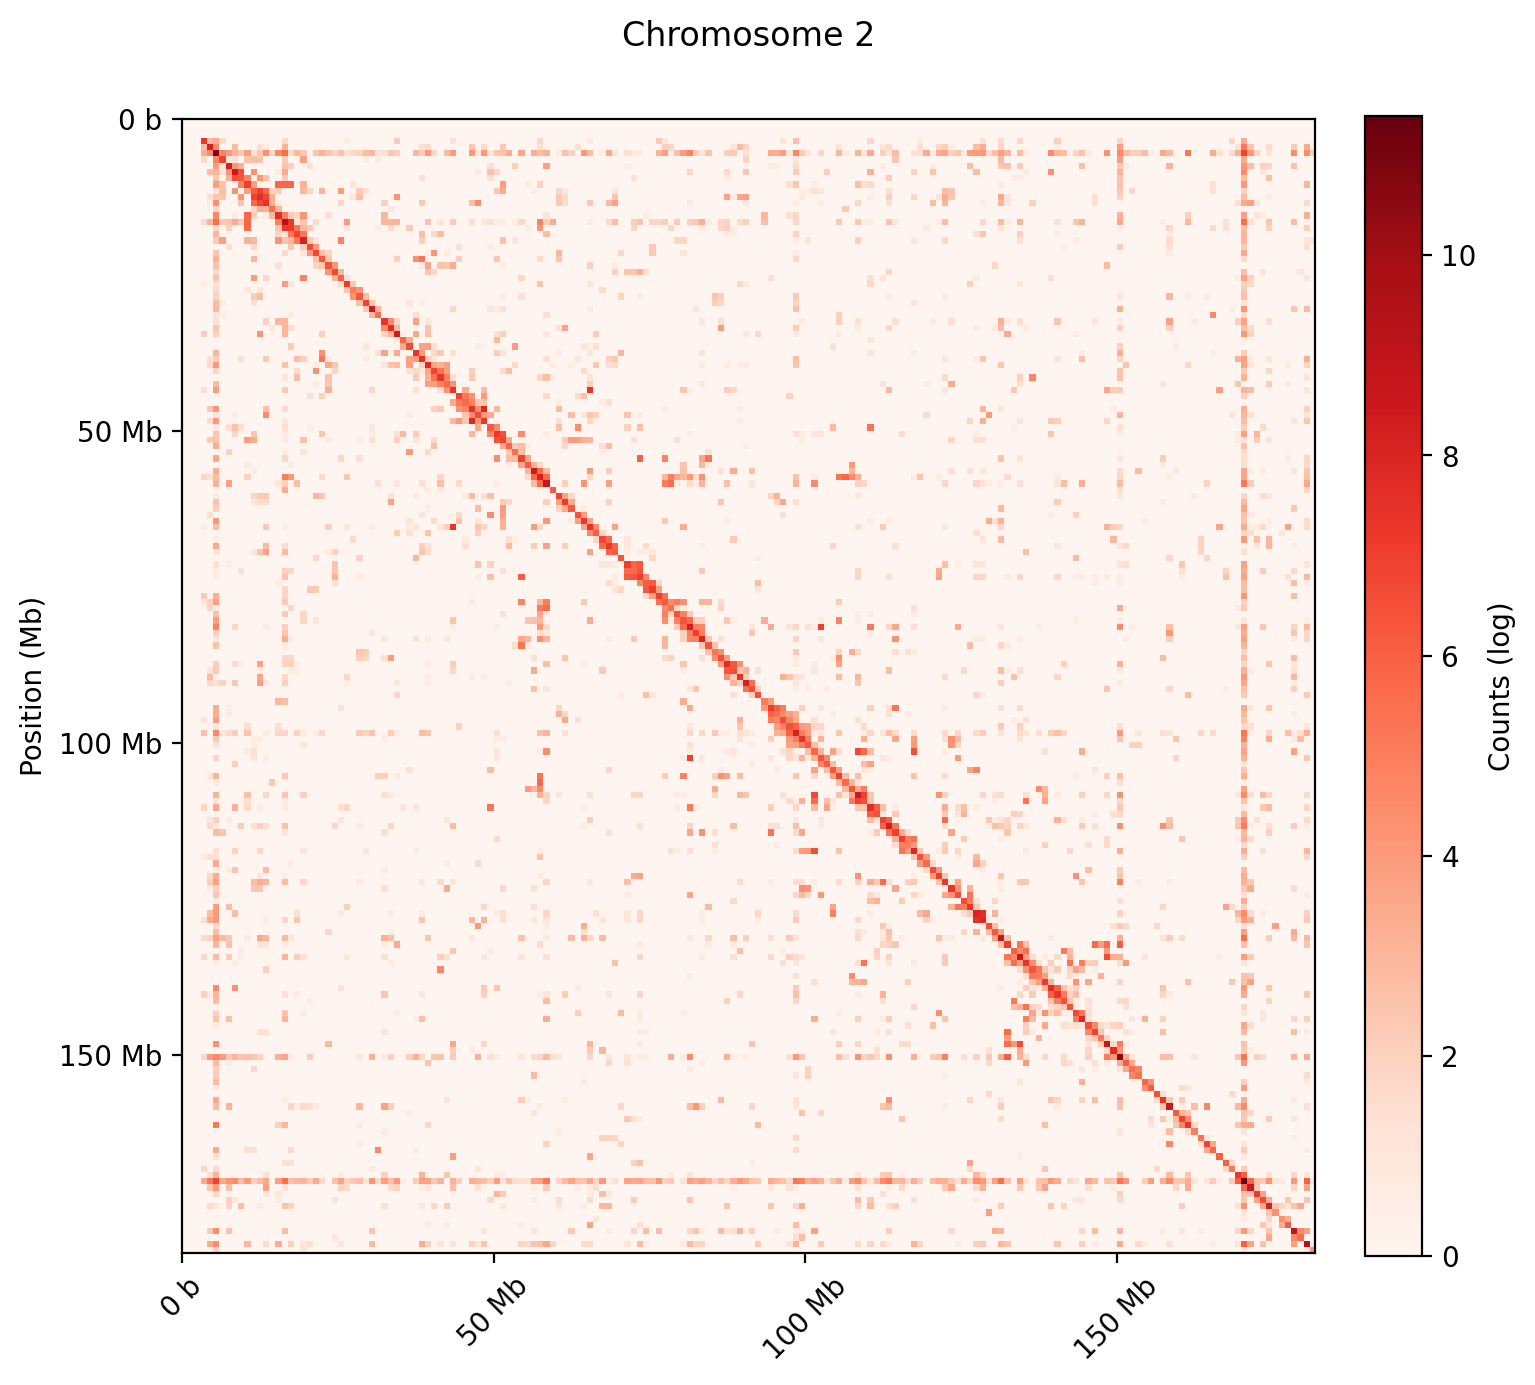

In [9]:
def plotHicMatrixChromosome(clr, chromosome, log=False, balance=False):
    
    A = clr.matrix(balance=balance).fetch(chromosome)
    if log:
        A = np.ma.log(A).filled(0) # log scale

    im = plt.matshow(
        A,
        extent=(0,clr.chromsizes[chromosome], clr.chromsizes[chromosome], 0),
        cmap='Reds'
    );

    if log:
        plt.colorbar(im, fraction=0.046, pad=0.04, label='Counts (log)');
    elif balance:
        plt.colorbar(im, fraction=0.046, pad=0.04, label='Counts (normalized)');
    else:
        plt.colorbar(im, fraction=0.046, pad=0.04, label='Counts');
        
    ax = plt.gca()
    format_ticks(ax)


    
chrom = 'NC_000068.8'
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 8

plotHicMatrixChromosome(clr, chrom, log=True, balance=False)
titleString = f"Chromosome {chromMap[chrom]}"
plt.title(titleString)
plt.ylabel('Position (Mb)')


In [10]:
# break

# KR Balancing

In [11]:
bias, stats = cooler.balance_cooler(clr, rescale_marginals=True)

clr.bins()[:]['weight'] = bias
clr.bins()[:3]

INFO:cooler.balance:variance is 7031314884.124446
INFO:cooler.balance:variance is 3601785029.051504
INFO:cooler.balance:variance is 306235764.2233154
INFO:cooler.balance:variance is 3080839518.609856
INFO:cooler.balance:variance is 212646291.41995454
INFO:cooler.balance:variance is 2462017406.434736
INFO:cooler.balance:variance is 145303194.2959023
INFO:cooler.balance:variance is 1973286394.9391477
INFO:cooler.balance:variance is 100092882.52660324
INFO:cooler.balance:variance is 1577219642.7107773
INFO:cooler.balance:variance is 70641481.79298982
INFO:cooler.balance:variance is 1261410560.5417926
INFO:cooler.balance:variance is 51360119.49453666
INFO:cooler.balance:variance is 1013191763.587004
INFO:cooler.balance:variance is 38513581.17051718
INFO:cooler.balance:variance is 819111036.2902248
INFO:cooler.balance:variance is 29770881.283502556
INFO:cooler.balance:variance is 667172522.5683811
INFO:cooler.balance:variance is 23691473.213244632
INFO:cooler.balance:variance is 547644438.3

,chrom,start,end,weight
0,NC_000067.7,0,1000000,0.003191
1,NC_000067.7,1000000,2000000,0.003191
2,NC_000067.7,2000000,3000000,0.003191


Text(0, 0.5, 'Position (Mb)')

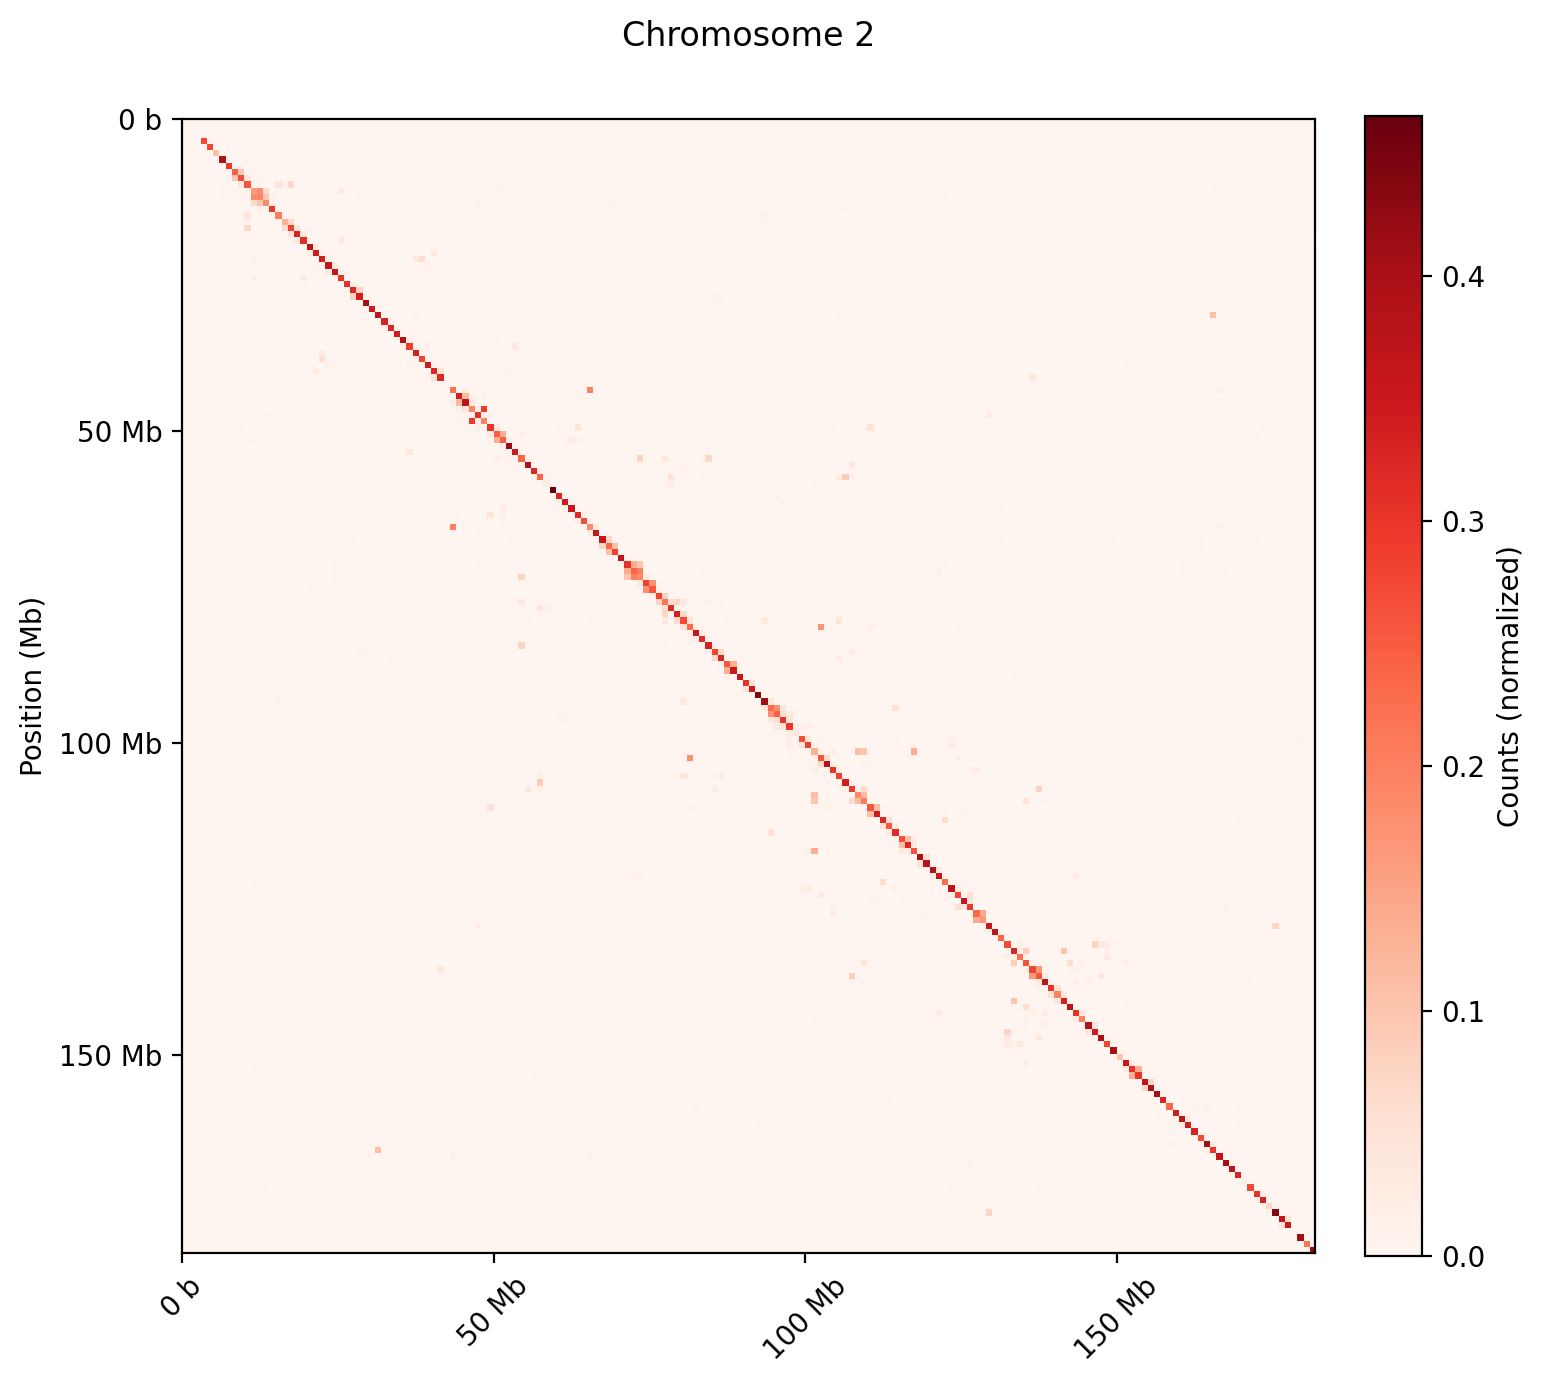

In [12]:
chrom = 'NC_000068.8'
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 8

plotHicMatrixChromosome(clr, chrom, log=False, balance=True)
titleString = f"Chromosome {chromMap[chrom]}"
plt.title(titleString)
plt.ylabel('Position (Mb)')

Text(0.5, 0, 'Position (Mb)')

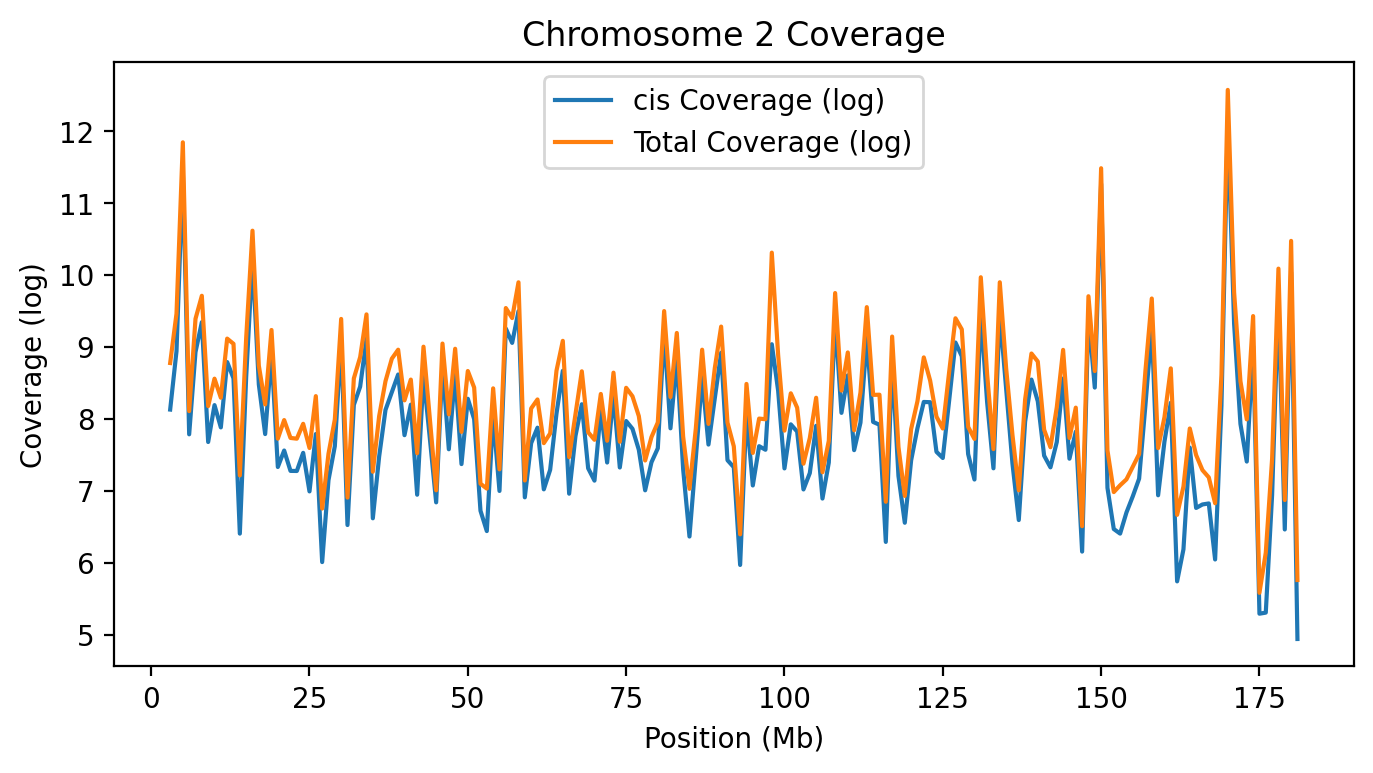

In [13]:


def plotCoverageChromosome(clr, chrom, log=True):
    cis_coverage, tot_coverage = cooltools.coverage(clr)
    extent = clr.extent(chrom)
    
    if log:
        cis_coverage = np.ma.log(cis_coverage)
        tot_coverage = np.ma.log(tot_coverage)
    
        plt.plot(cis_coverage[extent[0]:extent[1]], label='cis Coverage (log)')
        plt.plot(tot_coverage[extent[0]:extent[1]], label='Total Coverage (log)')
    else:        
        plt.plot(cis_coverage[extent[0]:extent[1]], label='cis Coverage')
        plt.plot(tot_coverage[extent[0]:extent[1]], label='Total Coverage')
    plt.legend()
    
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4
plotCoverageChromosome(clr, chrom)
titleString = f"Chromosome {chromMap[chrom]} Coverage"
plt.title(titleString)
plt.ylabel('Coverage (log)')
plt.xlabel('Position (Mb)')


<ipython-input-14-fecd71f779a0>:4: RuntimeWarning: invalid value encountered in true_divide
  ratio = cis_coverage[extent[0]:extent[1]] / tot_coverage[extent[0]:extent[1]]


Text(0.5, 0, 'Position (Mb)')

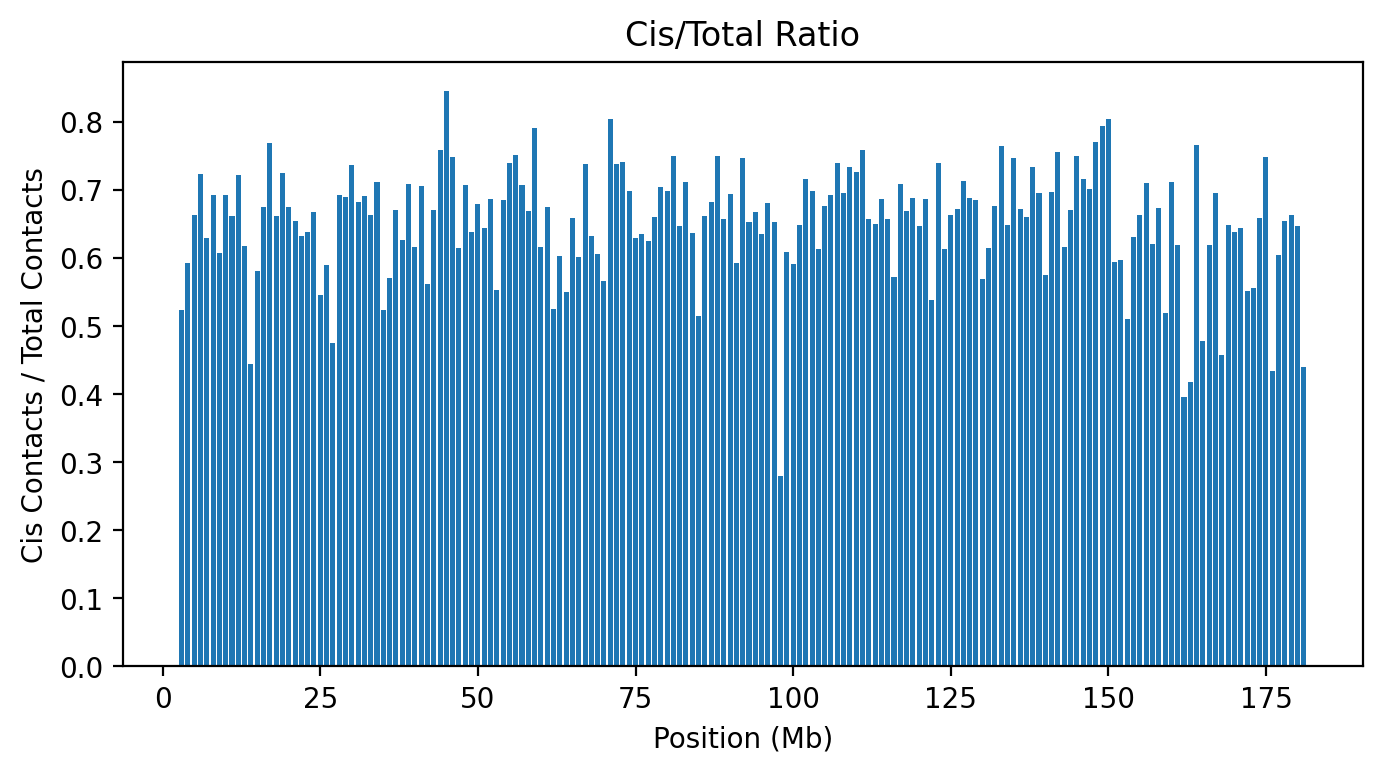

In [14]:
cis_coverage, tot_coverage = cooltools.coverage(clr)
extent = clr.extent(chrom)

ratio = cis_coverage[extent[0]:extent[1]] / tot_coverage[extent[0]:extent[1]] 
plt.bar(range(len(ratio)), ratio)
plt.title('Cis/Total Ratio')
plt.ylabel('Cis Contacts / Total Contacts')
plt.xlabel('Position (Mb)')

# Smoothing

In [15]:


# cg = cooltools.lib.numutils.adaptive_coarsegrain(clr.matrix(balance=True).fetch(chrom),
#                                                  clr.matrix(balance=False).fetch(chrom),
#                                                  cutoff=10, 
#                                                  max_levels=20)

# cgi = cooltools.lib.numutils.interp_nan(cg)

# im = plt.matshow(
#     cgi,
#     extent=(0,clr.chromsizes[chrom], clr.chromsizes[chrom], 0),
#     cmap='Reds'
# );


# ax = plt.gca()
# format_ticks(ax)


# Insulation

In [16]:
import cooltools.lib.plotting
from cooltools import insulation

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

In [17]:
resolution = 100000

clr = cooler.Cooler(f'{filepath}::resolutions/{resolution}')


# balance the matrix
bias, stats = cooler.balance_cooler(clr, rescale_marginals=True)
clr.bins()[:]['weight'] = bias

INFO:cooler.balance:variance is 745126754.874405
INFO:cooler.balance:variance is 680057361.0682867
INFO:cooler.balance:variance is 957745536.7671165
INFO:cooler.balance:variance is 76908158936.93051
INFO:cooler.balance:variance is 35360097577.10437
INFO:cooler.balance:variance is 3217789169332.8716
INFO:cooler.balance:variance is 927528925322.116
INFO:cooler.balance:variance is 85573201541981.2
INFO:cooler.balance:variance is 18968105605985.54
INFO:cooler.balance:variance is 1755182359199568.5
INFO:cooler.balance:variance is 328747777576755.7
INFO:cooler.balance:variance is 3.046315718122081e+16
INFO:cooler.balance:variance is 5088629943487881.0
INFO:cooler.balance:variance is 4.711232621463203e+17
INFO:cooler.balance:variance is 7.260197729744768e+16
INFO:cooler.balance:variance is 6.70086900171758e+18
INFO:cooler.balance:variance is 9.739608466930903e+17
INFO:cooler.balance:variance is 8.94797384106472e+19
INFO:cooler.balance:variance is 1.2450428695612154e+19
INFO:cooler.balance:var

In [18]:
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=False)
insulation_table.head()

,chrom,start,end,region,is_bad_bin,log2_insulation_score_300000,n_valid_pixels_300000,log2_insulation_score_500000,n_valid_pixels_500000,log2_insulation_score_1000000,...,log2_insulation_score_2500000,n_valid_pixels_2500000,boundary_strength_300000,boundary_strength_500000,boundary_strength_1000000,boundary_strength_2500000,is_boundary_300000,is_boundary_500000,is_boundary_1000000,is_boundary_2500000
0,NC_000067.7,0,100000,NC_000067.7,False,NaN,3.0,NaN,5.0,NaN,...,NaN,25.0,NaN,NaN,NaN,NaN,False,False,False,False
1,NC_000067.7,100000,200000,NC_000067.7,False,NaN,6.0,NaN,10.0,NaN,...,NaN,50.0,NaN,NaN,NaN,NaN,False,False,False,False
2,NC_000067.7,200000,300000,NC_000067.7,False,NaN,9.0,NaN,15.0,NaN,...,NaN,75.0,NaN,NaN,NaN,NaN,False,False,False,False
3,NC_000067.7,300000,400000,NC_000067.7,False,NaN,9.0,NaN,20.0,NaN,...,NaN,100.0,NaN,NaN,NaN,NaN,False,False,False,False
4,NC_000067.7,400000,500000,NC_000067.7,False,NaN,9.0,NaN,25.0,NaN,...,NaN,125.0,NaN,NaN,NaN,NaN,False,False,False,False


In [19]:
def rotate45deg(data, resolution=1):
    start_pos_vector = [0+resolution*i for i in range(len(data)+1)]
    n = data.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    A = np.dot(np.array([(i[1], i[0])
                         for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = A[:, 1].reshape(n + 1, n + 1)
    y = A[:, 0].reshape(n + 1, n + 1)
    
    return x, y

In [20]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
#     im.set_rasterized(True)
    return im

In [21]:
insulation_table.columns

Index(['chrom', 'start', 'end', 'region', 'is_bad_bin',
       'log2_insulation_score_300000', 'n_valid_pixels_300000',
       'log2_insulation_score_500000', 'n_valid_pixels_500000',
       'log2_insulation_score_1000000', 'n_valid_pixels_1000000',
       'log2_insulation_score_2500000', 'n_valid_pixels_2500000',
       'boundary_strength_300000', 'boundary_strength_500000',
       'boundary_strength_1000000', 'boundary_strength_2500000',
       'is_boundary_300000', 'is_boundary_500000', 'is_boundary_1000000',
       'is_boundary_2500000'],
      dtype='object')

<ipython-input-39-f9fa59fcf3d3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insul_region['midpoint'] = insul_region[['start', 'end']].mean(axis=1)


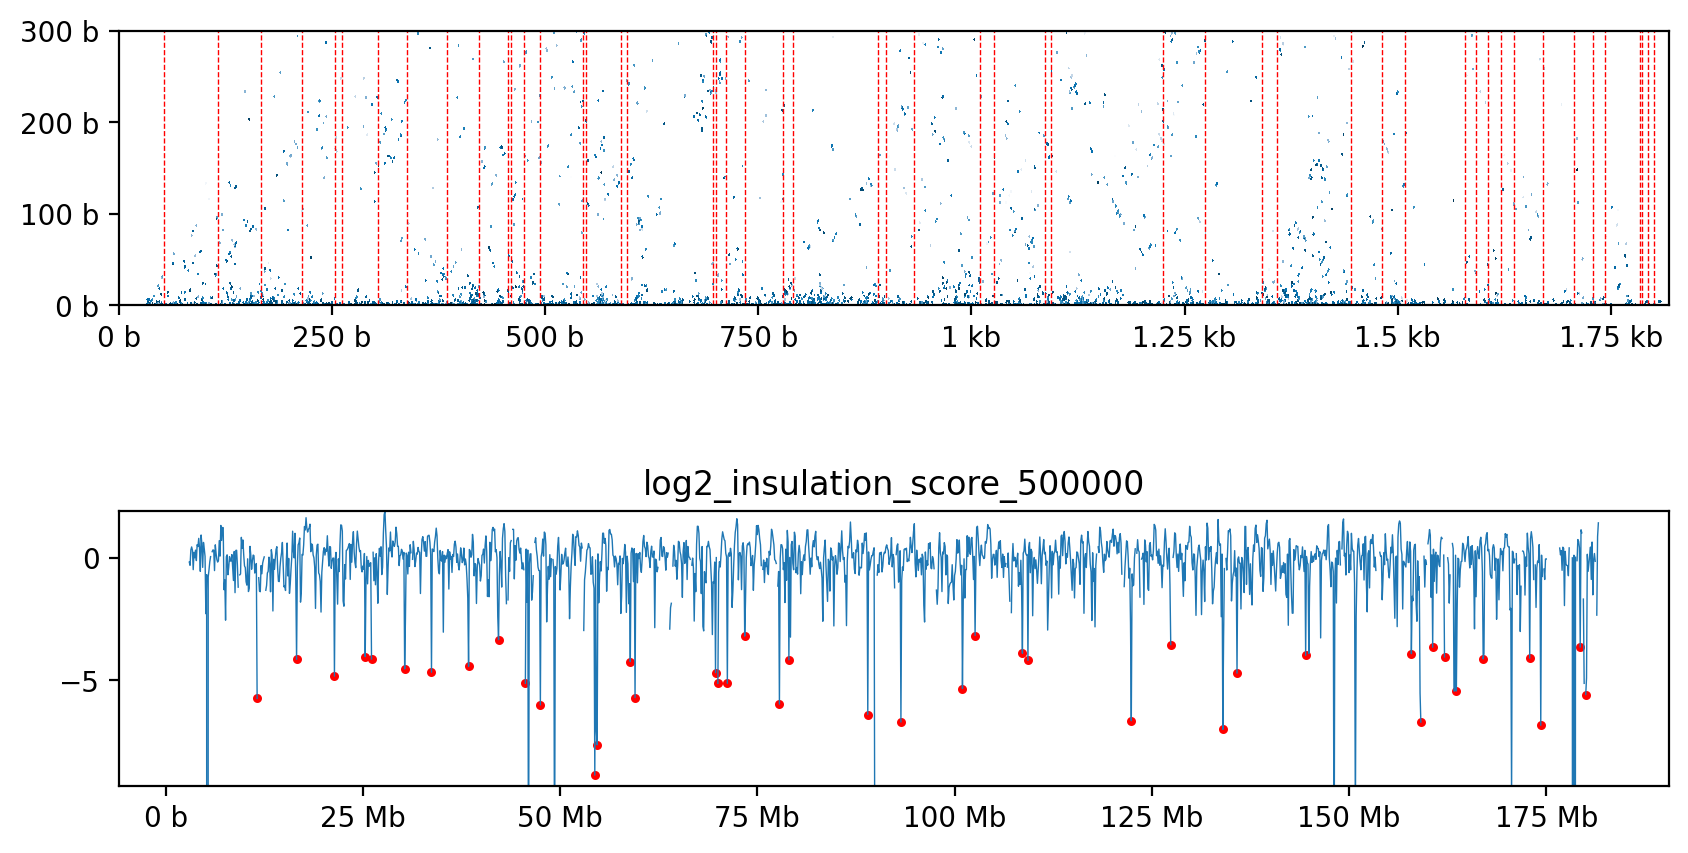

In [39]:
start = clr.extent(chrom)[0]
end = clr.extent(chrom)[1]
region = (chrom, start, end)
ylim = 300 # in base pairs
insultionValue = windows[1]
insulationColumn = f'log2_insulation_score_{insultionValue}'
boundaryColumn = f'is_boundary_{insultionValue}'


# get region
insul_region = bioframe.select(insulation_table, chrom)
insul_region['midpoint'] = insul_region[['start', 'end']].mean(axis=1)
isBoundary = insul_region[insul_region[boundaryColumn] == True]


norm = LogNorm(vmax=100, vmin=0.0001)
data = clr.matrix(balance=True).fetch(chrom)


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))


x, y = rotate45deg(data, resolution=1)
ax1.pcolormesh(x, y, np.flipud(data), cmap='blues',  norm=norm)

ax1.set_ylim(0, ylim)


for bound in isBoundary['midpoint']:
    binBound = bound / resolution
    ax1.axvline(x=binBound, lw=0.5, ls="--", c='r')

format_ticks(ax1, rotate=False)


# # plot insulation scores below
ax2.plot(insul_region['start'],
         insul_region[insulationColumn], 
         lw=0.5)


ylimMin = np.nanpercentile(insul_region[insulationColumn], 0.5)
# ylimMin = insul_region[insulationColumn].min()
ax2.set_ylim(ylimMin, insul_region[insulationColumn].max())
ax2.set_title(insulationColumn)

# add boundary calling
isBoundary = insul_region[insul_region[boundaryColumn] == True]

ax2.scatter(isBoundary['start'],
            isBoundary[insulationColumn], 
            c='r',
            s=5)
    

format_ticks(ax2, y=False, rotate=False)

plt.subplots_adjust(hspace = 0.75)


In [23]:
def loadTADBoundary(filepath):
    df = pd.read_csv(filepath, sep='\t', header=None)
    df.columns = ['phase', 'start', 'end', 'chrom']
    return df

def mergeAssembly(tad, assembly):
    
    tad['chrom'] = tad['chrom'].astype('str')
    tad = pd.merge(left=tad, 
                   right=assembly, 
                   left_on='chrom', 
                   right_on='Chromosome')
    
    return tad



tad = loadTADBoundary('F121_mESC_TADS.txt')
tad = mergeAssembly(tad, assembly)

binTAD(tad, resolution)


100000


In [32]:
clr.bins()[10000]

,chrom,start,end,weight
10000,NC_000073.7,1700000,1800000,9.479868e-28


In [28]:
tad['start'].max()

189706121

In [26]:
clr.binsize

100000